In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths, peak_prominences, medfilt
from scipy.ndimage import median_filter
import scipy as sp
import lightkurve as lk
import pylab as pl
from IPython import display
import pandas as pd
import copy
import os, shutil
from lightkurve import periodogram
from astropy import units
from itertools import repeat
import time

from echelle import plot_echelle, interact_echelle

In [2]:
# star = 'TIC171591531'
# star = 'TIC189127221'
# star = 'TIC235612106'
# star = 'TIC416747795'
star = 'HD20203'
# star = 'V647Tau'
# star = 'KIC 9845907'

# try:
#     lc = lk.search_lightcurve(star, mission="TESS", cadence=120, author="SPOC")[0].download().normalize()
# except:
#     lc = lk.search_lightcurve(star, mission="TESS", cadence=600, author="TESS-SPOC")[0].download().normalize()
# lc = lc.remove_nans().remove_outliers()
# time, flux = lc.time.value, lc.flux.value


lc_collection = lk.search_lightcurve(star, mission="TESS", cadence=120, author="SPOC").download_all()
fmax = 90
if lc_collection is None:
    print (f"No 2-min LK for {star}, try FFI data...")
    lc_collection = lk.search_lightcurve(star, mission="TESS", cadence=600, author="TESS-SPOC").download_all()
    fmax = 72
    snr_threshold = 4
if lc_collection is None:
    print (f"No FFI LK for {star}, passing...")
    pass
else:
    lc = lc_collection[0].normalize() # defaults to pdcsap_flux now.
    for l in lc_collection[1:]:
        lc = lc.append(l.normalize())
    lc = lc.remove_nans().remove_outliers()

    # Extract time and flux from the light curve
    t, flux = lc.time.value, lc.flux.value

t_list = [t]
flux_list = [flux]

### Amplitude Spectrum

In [3]:
def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    amp = np.sqrt(4./len(t)) * np.sqrt(sc)

    return freq, amp

def make_id_strings(ids):
    id_strings = []
    ids = ids.query("n_obs==n_obs") # remove rows without radial order assignments (modes without IDs)
    if "m_obs" not in ids.columns:
        ids["m_obs"] = np.zeros(len(ids)) # create m_obs, but set to zero, if this column doesn't exist
    for i,row in ids.iterrows():
        id_strings.append(str(int(row["n_obs"]))+str(int(row["l_obs"]))+str(int(row["m_obs"])))
    ids["nlm"] = id_strings
    return ids

def extra_echelle(f,a,ids,Dnu=6.83,obs_freqs=None,ax=None,plain=True,title=None,savefilename=None):
    """
    Plots the echelle diagram for a frequency and amplitude spectrum, including ell=2 and ell=3 modes.
    Inputs:
        f = frequency array
        a = amplitude array (same size as f, preferably smoothed)
        ids = Pandas df containing, e.g. frequencies and mode IDs.
        Dnu = 6.83 (not automatically determined)
        obs_freqs = None (for plotting observed frequencies with IDs when also plotting a full ts)
        plain = True (do not plot symbols if plain==True)
        title = None (supply a plot title)
        savefilename = None (supply a filename (incl. extension) to save plot)
    """

    norders = 15 # number of orders to plot

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8.5))
    ax2 = plot_echelle(f, a, Dnu, ax=ax, fmin=0, fmax=Dnu*(norders+1), mirror=True, scale='sqrt')
    ax.set_xlim(0, 1.2*Dnu)
    ax2.set_ylabel(r"Frequency (d$^{-1}$)")
    ax2.set_xlabel(r"Frequency mod $\Delta\nu$ (d$^{-1}$)")
    ax.set_ylim([0,Dnu*norders])
    plt.plot([Dnu, Dnu], [0, Dnu*norders], linestyle='dashed', color = 'blue')
    if title is not None:
        plt.title(f"{title}")

    if obs_freqs is not None:
        # obs radial modes
        add_echelle(obs_freqs.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

        # obs dipole modes
        add_echelle(obs_freqs.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
        
        # obs quadrupole modes
        add_echelle(obs_freqs.query("l_obs==2")["f_obs"],Dnu,'r','s','full',ax2,r'obs $\ell=2$')
        
        # obs octupole modes
#         add_echelle(obs_freqs.query("l_obs==3")["f_obs"],Dnu,'r','v','full',ax2,r'obs $\ell=3$')
        
        # obs no-id modes
        add_echelle(obs_freqs.query("l_obs==-1")["f_obs"],Dnu,'brown','x','full',ax2,r'unidentified')
        # add_echelle(obs_freqs.query("m_obs==-9")["f_obs"],Dnu,'brown','+','full',ax2,r'unidentified')

    if plain==False:
        try:
            # obs radial modes
            add_echelle(ids.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

            # obs dipole modes
            add_echelle(ids.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
            
            # obs quadrupole modes
            add_echelle(ids.query("l_obs==2")["f_obs"],Dnu,'r','s','full',ax2,r'obs $\ell=2$')

            # add_echelle(obs_freqs.query("m_obs==-9")["f_obs"],Dnu,'brown','+','full',ax2,r'unidentified')

            # obs octupole modes
#             add_echelle(ids.query("l_obs==3")["f_obs"],Dnu,'r','v','full',ax2,r'obs $\ell=3$')
        except:
            # print("could not find observed freqs")
            pass
        
        try:
            # model radial modes
            add_echelle(ids.query("l==0")["freq"],Dnu,'k','o','none',ax2,r'mdl $\ell=0$')
    
            # model dipole modes
            add_echelle(ids.query("l==1")["freq"],Dnu,'k','^','none',ax2,r'mdl $\ell=1$')

            # model quadrupole modes
            add_echelle(ids.query("l==2")["freq"],Dnu,'k','s','none',ax2,r'mdl $\ell=2$')
    
            # model octupole modes
            add_echelle(ids.query("l==3")["freq"],Dnu,'k','v','none',ax2,r'mdl $\ell=3$')
        except:
            # print("could not find model freqs")
            pass

    ax2.text(Dnu, Dnu*0.8, r"$\Delta\nu={:.2f}\thinspace$ ".format(Dnu), horizontalalignment='right', color='blue')

    try:
        ax.legend(fontsize='x-small')
    except:
        pass
    
    if savefilename is not None:
        plt.savefig(f"stars/{savefilename}",bbox_inches='tight')


def add_echelle(freq,Dnu,col,sym,fill,ax2,lbl=None):
    freq_x = np.mod(freq, Dnu) 
    freq_y = freq - np.mod(freq, Dnu) + Dnu/2.
    ax2.plot(freq_x, freq_y, c=col, marker=sym, linestyle='none', fillstyle=fill,label=lbl)
    ax2.plot(freq_x+Dnu, freq_y-Dnu, c=col, marker=sym, linestyle='none', fillstyle=fill)


### Utility Functions

In [102]:
# Sinusoidal function to fit the peaks
def sinusoidal_model(t, A, omega, phi, C):
    return A * np.sin(omega * t + phi) + C

def harmonics_check(df, harmonic_tolerance=0.01):
    df = df.sort_values(by='freq', ascending=True)
    df = df.reset_index(drop=True)
    harmonic_idx = []
    for i in range(len(df)-1):
        for j in range(i+1, len(df)):
            ratio = df.iloc[j]['freq']/df.iloc[i]['freq']
            closest_integer = round(ratio)
            if abs(ratio-closest_integer) < harmonic_tolerance and closest_integer > 1:
                df.loc[j, 'label'] = f'H{closest_integer}F{i}'
                harmonic_idx.append(j)
    base_idx = ~df.index.isin(harmonic_idx)
    df.loc[base_idx, 'label'] = [f'F{i}' for i in range(0, sum(base_idx))]
    return df

def remove_overlapping_freqs(df, nearby_tolerance=0.01):
    df = df.sort_values(by=['freq', 'amp'], ascending=False)
    df = df.reset_index(drop=True)
    to_drop = []
    for i in range(len(df)-1):
        if df.iloc[i]['freq'] - df.iloc[i+1]['freq'] < nearby_tolerance:
            if df.iloc[i]['amp'] < df.iloc[i+1]['amp']:
                to_drop.append(i)
            else:
                to_drop.append(i+1)
    return df.drop(index=to_drop)

In [103]:
def prewhitener1(time, flux, max_iterations=100, snr_threshold=5, f_sigma=3,
                remove_harmonics=True, harmonic_tolerance=0.001,  
                fmin=5, fmax=72, nyq_mult=1, oversample_factor=5, name='star'):
    if not os.path.exists(f'pw/{name}'):
        os.makedirs(f'pw/{name}')
    else:
        shutil.rmtree(f'pw/{name}')
        os.makedirs(f'pw/{name}')

    flux_i = copy.deepcopy(flux)

    peak_freqs = []
    peak_amps = []
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax1, ax2 = ax[0], ax[1]

    ## Initial amplitude spectrum
    freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps_i *= 1000 # convert to ppt
    for n in range(max_iterations):
        ## Find peaks
        peaks_i = find_peaks(amps_i)[0]

        # print(amps_i)
        
        ## If no peaks are found, break the loop
        if len(peaks_i) == 0:
            print('No more peaks found')
            break
        

        ## Fit and remove the highest peak
        amp = np.max(amps_i)
        freq = freqs_i[np.argmax(amps_i)]

        # Periodogram before pre-whitening
        ax1.cla()
        ax1.plot(freqs_i, amps_i)
        ax1.scatter(freq, amp, c='r', s=10, label='Frequecy to be extracted')
        ax1.set_title("Before")
        ax1.set_xlabel("Frequency (1/day)")
        ax1.set_ylabel("Amplitude (ppt)")

        omega = 2 * np.pi * freq
        p0 = [amp, omega, 0.5, 0.5]
        params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
        ## Negative amp corrections. Flip sign, add pi to phase
        if params[0] < 0:
            params[0] *= -1.
            params[2] += np.pi
        
        peak_freqs.append(params[1]/(2*np.pi))
        peak_amps.append(params[0]*1000)
        # peak_amps.append(amp)
        flux_i -= sinusoidal_model(time, *params)

        ### New amplitude spectrum ###
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        amps_i *= 1000 # convert to ppt

        ### SNR stopping condition ###
        noise = median_filter(amps_i, size=int(len(amps_i)*(freqs_i[1]-freqs_i[0])))
        snr = np.max(amps_i) / np.median(noise)
        print(snr)
        if snr < snr_threshold:
            # print('SNR threshold reached')
            break

        # Periodogram after pre-whitening
        ax2.cla()
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        ax2.plot(freqs_i, amps_i)
        ax2.set_title("After")
        ax2.set_xlabel("Frequency (1/day)")
        ax2.set_ylabel("Amplitude (ppt)")
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_ylim(ax1.get_ylim())
        # plt.savefig(f'pw/{name}/pg_{n+1}', bbox_inches='tight')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    plt.close()

    freq_amp = pd.DataFrame({'freq': peak_freqs, 'amp': peak_amps}).sort_values(by='freq')

    ## Remove overlapping or very nearby peaks, keep the highest amplitude one
    freq_amp = remove_overlapping_freqs(freq_amp, nearby_tolerance=0.1)

    # ## Harmonics check
    # freq_amp = harmonics_check(freq_amp, harmonic_tolerance=harmonic_tolerance)

    # Final periodogram after pre-whitening
    freqs, amps = amp_spectrum(t=time, y=flux, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps *= 1000 # convert to ppt

    # Save the frequencies and amplitudes
    freq_amp.to_csv(f'pw/{name}/frequencies.csv', index=False)
    # return freq_amp.freq.values, freq_amp.amp.values
    return freq_amp

In [6]:
def prewhitener3(time, flux, max_iterations=100, snr_threshold=5, f_sigma=3,
                remove_harmonics=True, harmonic_tolerance=0.001,  
                fmin=5, fmax=72, nyq_mult=1, oversample_factor=5, name='star'):
    if not os.path.exists(f'pw/{name}'):
        os.makedirs(f'pw/{name}')
    else:
        shutil.rmtree(f'pw/{name}')
        os.makedirs(f'pw/{name}')

    ## Normalize the flux
    flux_i = copy.deepcopy(flux)

    peak_freqs = []
    peak_amps = []
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax1, ax2 = ax[0], ax[1]

    ## Initial amplitude spectrum
    freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps_i *= 1000 # convert to ppt
    for n in range(max_iterations):
        ## Find peaks
        peaks_i = find_peaks(amps_i)[0]
        
        ## If no peaks are found, break the loop
        if len(peaks_i) == 0:
            print('No more peaks found')
            break
        

        ## Fit and remove the highest peak
        amp = np.max(amps_i)
        freq = freqs_i[np.argmax(amps_i)]

        # Periodogram before pre-whitening
        ax1.cla()
        ax1.plot(freqs_i, amps_i)
        ax1.scatter(freq, amp, c='r', s=10, label='Frequecy to be extracted')
        ax1.set_title("Before")
        ax1.set_xlabel("Frequency (1/day)")
        ax1.set_ylabel("Amplitude (ppt)")

        omega = 2 * np.pi * freq
        p0 = [amp, omega, 0.5, 0.5]
        params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
        ## Negative amp corrections. Flip sign, add pi to phase
        if params[0] < 0:
            params[0] *= -1.
            params[2] += np.pi
        
        peak_freqs.append(params[1]/(2*np.pi))
        peak_amps.append(params[0]*1000)
        # peak_amps.append(amp)
        flux_i -= sinusoidal_model(time, *params)

        ### New amplitude spectrum ###
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        amps_i *= 1000 # convert to ppt

        ### SNR stopping condition ###
        T = 0.1
        local_noise = np.mean(amps_i[(freqs_i > freq - 1/T) & (freqs_i < freq + 1/T)])
        local_snr = amp / local_noise
        print(local_snr)
        if local_snr < snr_threshold:
            # print('SNR threshold reached')
            break

        # Periodogram after pre-whitening
        ax2.cla()
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        ax2.plot(freqs_i, amps_i)
        ax2.set_title("After")
        ax2.set_xlabel("Frequency (1/day)")
        ax2.set_ylabel("Amplitude (ppt)")
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_ylim(ax1.get_ylim())
        # plt.savefig(f'pw/{name}/pg_{n+1}', bbox_inches='tight')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    plt.close()

    freq_amp = pd.DataFrame({'freq': peak_freqs, 'amp': peak_amps}).sort_values(by='freq')
    labels = ['F'+str(i) for i in range(len(freq_amp))]
    freq_amp['label'] = labels

    ## Sorting the peaks by freq
    freq_amp = harmonics_check(freq_amp, harmonic_tolerance=harmonic_tolerance)

    # ## Remove overlapping or very nearby peaks, keep the highest amplitude one
    # freq_amp = remove_overlapping_freqs(freq_amp, nearby_tolerance=0.01)

    # Final periodogram after pre-whitening
    freqs, amps = amp_spectrum(t=time, y=flux, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps *= 1000 # convert to ppt

    # Save the frequencies and amplitudes
    freq_amp.to_csv(f'pw/{name}/frequencies.csv', index=False)
    # return freq_amp.freq.values, freq_amp.amp.values
    return freq_amp

In [7]:
def prewhitener2(time, flux, max_iterations=100, snr_threshold=5, f_sigma=3,
                remove_harmonics=True, harmonic_tolerance=0.001,  
                fmin=5, fmax=72, nyq_mult=1, oversample_factor=5, name='star'):
    if not os.path.exists(f'pw/{name}'):
        os.makedirs(f'pw/{name}')
    else:
        shutil.rmtree(f'pw/{name}')
        os.makedirs(f'pw/{name}')

    ## Normalize the flux
    flux_i = copy.deepcopy(flux)

    peak_freqs = []
    peak_amps = []
    peaks = []

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax1, ax2 = ax[0], ax[1]
    ## Initial amplitude spectrum
    freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps_i *= 1000 # convert to ppt
    for n in range(max_iterations):
        ## Find all peaks to calculate the median prominence and width
        peaks_tmp = find_peaks(amps_i)[0]

        prominence_data = peak_prominences(amps_i, peaks=peaks_tmp)
        prominence = np.median(prominence_data[0])
        peaks_widths_i = peak_widths(amps_i, peaks=peaks_tmp, rel_height=0.5, prominence_data=prominence_data)[0]
        width = np.median(peaks_widths_i)  ## median fwhm 
        # distance = width/(np.median(np.diff(freqs_i)))
        # distance = len(amps_i)/width
        distance = 720/(1/27)

        ## Find all peaks that fit the above criteria
        peaks_i = find_peaks(amps_i, height=np.median(amps_i)+f_sigma*np.std(amps_i), 
                             width=width, 
                             prominence=prominence,
                             distance=distance)[0].tolist()
        
        ## If no peaks are found, break the loop
        if len(peaks_i) == 0:
            print('No more peaks found')
            break
        # Periodogram before pre-whitening
        ax1.cla()
        ax1.plot(freqs_i, amps_i)
        ax1.scatter(freqs_i[peaks_i], amps_i[peaks_i], c='r', s=10, label='Frequecies to be extracted')
        ax1.set_title("Before")
        ax1.set_xlabel("Frequency (1/day)")
        ax1.set_ylabel("Normalised Amplitude (ppt)")


        ## Add the peaks to the list
        peaks += peaks_i
        ## Fitting the sinusoids and subtracting them from the original signal
        for freq, amp in zip(freqs_i[peaks_i], amps_i[peaks_i]):
            omega = 2 * np.pi * freq
            p0 = [amp, omega, 0.5, 0.5]
            params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
            ## Negative amp corrections. Flip sign, add pi to phase
            if params[0] < 0:
                params[0] *= -1.
                params[2] += np.pi

            flux_i -= sinusoidal_model(time, *params)
            ### New amplitude spectrum ###
            freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
            amps_i *= 1000 # convert to ppt

            ### SNR stopping condition ###
            noise = median_filter(amps_i, size=int(len(amps_i)*(freqs_i[1]-freqs_i[0])))
            snr = np.max(amps_i) / np.median(noise)
            if snr < snr_threshold:
                # print('SNR threshold reached')
                break_now = True
                break
            else:
                peak_freqs.append(params[1]/(2*np.pi))
                peak_amps.append(params[0]*1000)
            # Periodogram after pre-whitening
            ax2.cla()
            freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
            ax2.plot(freqs_i, amps_i)
            ax2.set_title("After")
            ax2.set_xlabel("Frequency (1/day)")
            ax2.set_ylabel("Amplitude (ppt)")
            ax2.set_xlim(ax1.get_xlim())
            ax2.set_ylim(ax1.get_ylim())
            # plt.savefig(f'pw/{name}/pg_{n+1}', bbox_inches='tight')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            continue
        break
    plt.close()


    freq_amp = pd.DataFrame({'freq': peak_freqs, 'amp': peak_amps})

    ## Sorting the peaks by freq
    freq_amp = harmonics_check(freq_amp, harmonic_tolerance=harmonic_tolerance)

    # ## Remove overlapping or very nearby peaks, keep the highest amplitude one
    # freq_amp = remove_overlapping_freqs(freq_amp, nearby_tolerance=0.01)

    # Final periodogram after pre-whitening
    freqs, amps = amp_spectrum(t=time, y=flux, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps *= 1000 # convert to ppt

    # Save the frequencies and amplitudes
    freq_amp.to_csv(f'pw/{name}/frequencies.csv', index=False)
    return freq_amp.freq.values, freq_amp.amp.values

In [16]:
def prewhitener4(time, flux, max_iterations=100, snr_threshold=5, f_sigma=3,
                remove_harmonics=True, harmonic_tolerance=0.001,  
                fmin=5, fmax=72, nyq_mult=1, oversample_factor=5, name='star'):
    if not os.path.exists(f'pw/{name}'):
        os.makedirs(f'pw/{name}')
    else:
        shutil.rmtree(f'pw/{name}')
        os.makedirs(f'pw/{name}')

    ## Normalize the flux
    flux_i = copy.deepcopy(flux)

    peak_freqs = []
    peak_amps = []
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax1, ax2 = ax[0], ax[1]

    ## Initial amplitude spectrum
    freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps_i *= 1000 # convert to ppt
    for n in range(max_iterations):
        ## Find peaks
        peaks_i = find_peaks(amps_i)[0]
        
        ## If no peaks are found, break the loop
        if len(peaks_i) == 0:
            print('No more peaks found')
            break
        

        ## Fit and remove the highest peak
        amp = np.max(amps_i)
        freq = freqs_i[np.argmax(amps_i)]

        # Periodogram before pre-whitening
        ax1.cla()
        ax1.plot(freqs_i, amps_i)
        ax1.scatter(freq, amp, c='r', s=10, label='Frequecy to be extracted')
        ax1.set_title("Before")
        ax1.set_xlabel("Frequency (1/day)")
        ax1.set_ylabel("Amplitude (ppt)")

        omega = 2 * np.pi * freq
        p0 = [amp, omega, 0.5, 0.5]
        params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
        ## Negative amp corrections. Flip sign, add pi to phase
        if params[0] < 0:
            params[0] *= -1.
            params[2] += np.pi
        
        peak_freqs.append(params[1]/(2*np.pi))
        peak_amps.append(params[0]*1000)
        flux_i -= sinusoidal_model(time, *params)

        ### New amplitude spectrum ###
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        amps_i *= 1000 # convert to ppt

        ### SNR stopping condition ###
        reso = 0.037
        local_noise = np.mean(amps_i[(freqs_i > freq - reso) & (freqs_i < freq + reso)])
        local_snr = amp / local_noise
        print(local_snr)
        if local_snr < snr_threshold:
            # print('SNR threshold reached')
            break

        # Periodogram after pre-whitening
        ax2.cla()
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        ax2.plot(freqs_i, amps_i)
        ax2.set_title("After")
        ax2.set_xlabel("Frequency (1/day)")
        ax2.set_ylabel("Amplitude (ppt)")
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_ylim(ax1.get_ylim())
        # plt.savefig(f'pw/{name}/pg_{n+1}', bbox_inches='tight')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    plt.close()

    freq_amp = pd.DataFrame({'freq': peak_freqs, 'amp': peak_amps}).sort_values(by='freq')
    labels = ['F'+str(i) for i in range(len(freq_amp))]
    freq_amp['label'] = labels

    ## Sorting the peaks by freq
    freq_amp = harmonics_check(freq_amp, harmonic_tolerance=harmonic_tolerance)

    ## Remove overlapping or very nearby peaks, keep the highest amplitude one
    freq_amp = remove_overlapping_freqs(freq_amp, nearby_tolerance=0.01)

    # Final periodogram after pre-whitening
    freqs, amps = amp_spectrum(t=time, y=flux, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps *= 1000 # convert to ppt

    # Save the frequencies and amplitudes
    freq_amp.to_csv(f'pw/{name}/frequencies.csv', index=False)
    # return freq_amp.freq.values, freq_amp.amp.values
    return freq_amp

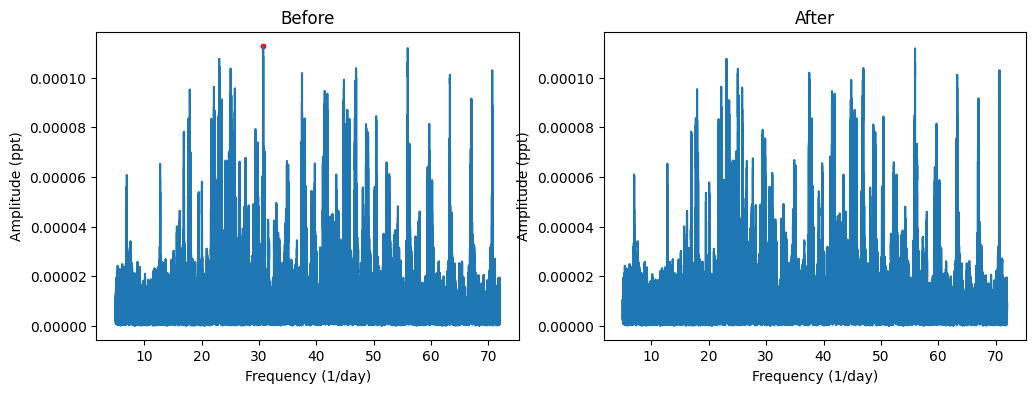

9.986926111752206


In [104]:
start = time.time()
for t, flux in zip(t_list, flux_list):
    freq_amp = prewhitener1(t, flux, snr_threshold=10, remove_harmonics=True, harmonic_tolerance=1/27, f_sigma=3)
    peak_freqs1, peak_amps1 = freq_amp.freq.values, freq_amp.amp.values
end = time.time()
time_taken_1 = (end-start)/len(t_list)

In [105]:
def harmonics_check(df, harmonic_tolerance=0.01):
    df = df.sort_values(by='freq', ascending=True)
    df = df.reset_index(drop=True)
    harmonic_idx = []
    for i in range(len(df)-1):
        for j in range(i+1, len(df)):
            ratio = df.iloc[j]['freq']/df.iloc[i]['freq']
            closest_integer = round(ratio)
            if abs(ratio-closest_integer) < harmonic_tolerance and closest_integer > 1:
                df.loc[j, 'label'] = f'H{closest_integer}F{i}'
                harmonic_idx.append(j)
    base_idx = ~df.index.isin(harmonic_idx)
    df.loc[base_idx, 'label'] = [f'F{i}' for i in range(0, sum(base_idx))]
    return df

harmonics_check(freq_amp, harmonic_tolerance=0.01)

,freq,amp,label
0,16.746377,0.171826,F0
1,17.281310,0.189404,F1
2,18.726258,0.114038,F2
3,18.863305,0.266476,F3
4,20.462622,0.138260,F4
5,21.747408,4.548760,F5
6,22.784236,0.129814,F6
7,22.967963,0.240762,F7
8,23.547330,0.120439,F8
9,24.167091,0.554190,F9


In [27]:
peak_freqs1/peak_freqs1[0] - round(peak_freqs1/peak_freqs1[0])

TypeError: type numpy.ndarray doesn't define __round__ method

In [63]:
round(1.49)

1

/var/folders/sb/dk38f76562ng2fhw85ll93vc0000gp/T/ipykernel_8568/3666961531.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 1, 1)


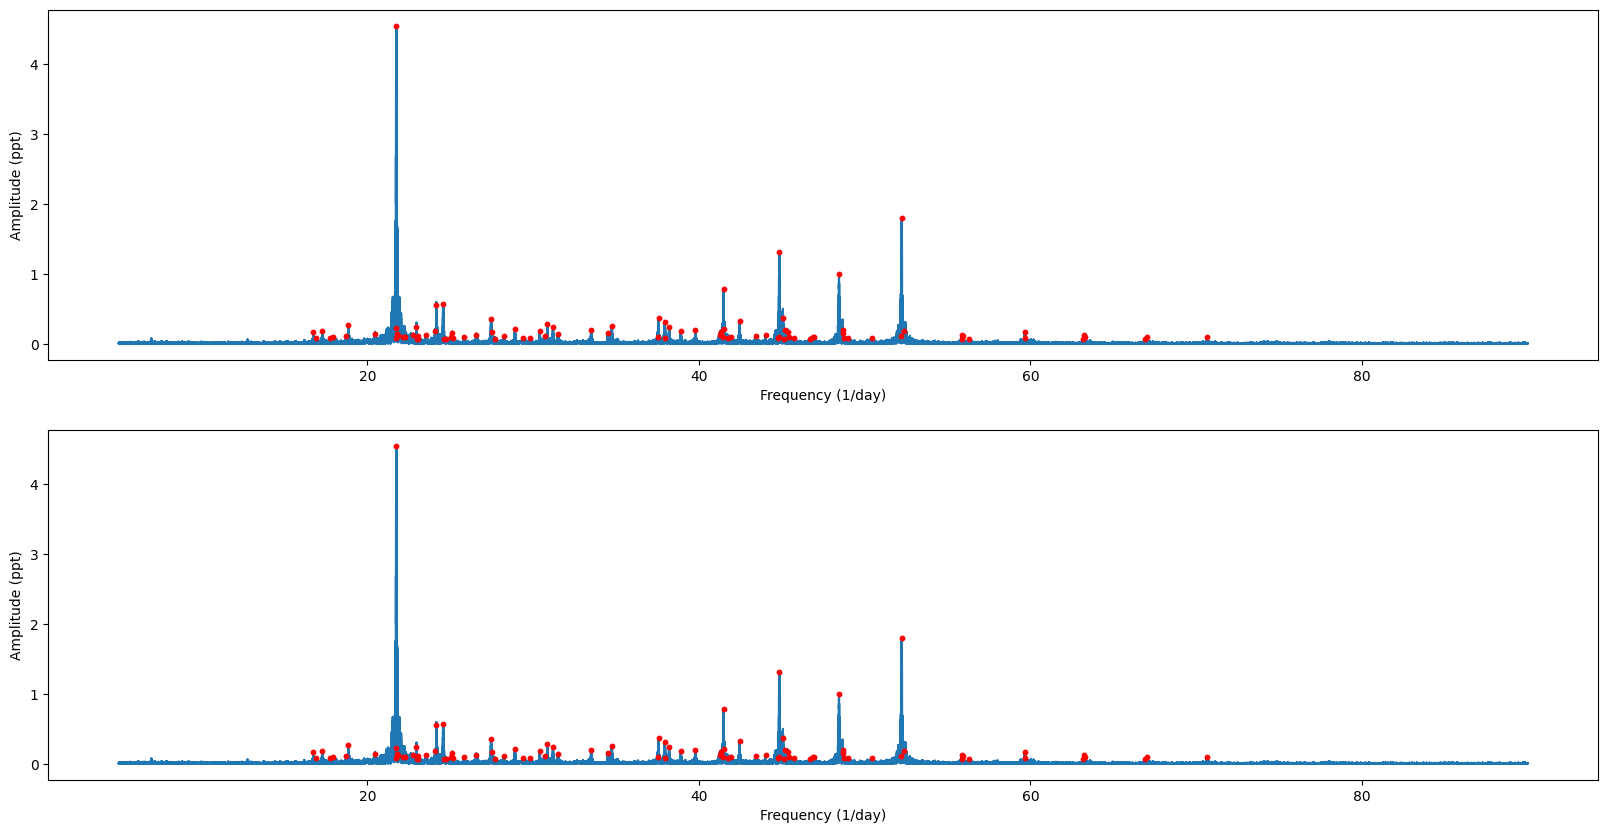

In [18]:
# Plot the final periodogram after pre-whitening
freqs, amps = amp_spectrum(t=t, y=flux, fmin=5, fmax=90, nyq_mult=1, oversample_factor=5)
amps *= 1000
plt.figure(figsize=(20, 10))
plt.title("Lomb-Scargle Periodogram with peaks")

ax1 = plt.subplot(2, 1, 1)
ax1.plot(freqs, amps, zorder=1)
ax1.scatter(peak_freqs2, peak_amps2, s=10, color='red', zorder=2)
ax1.set_xlabel("Frequency (1/day)")
ax1.set_ylabel("Amplitude (ppt)")
# ax1.set_xlim(0, 70)
# ax1.set_xlim(20, 30)
# ax1.set_xlim(5, 15)
# ax1.set_xlim(25, 60)
# ax1.set_xlim(70.68-0.037,70.68+0.037)
# ax1.set_ylim(0,0.3)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(freqs, amps, zorder=1)
ax2.scatter(peak_freqs2, peak_amps2, s=10, color='red', zorder=2)
ax2.set_xlabel("Frequency (1/day)")
ax2.set_ylabel("Amplitude (ppt)")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

plt.show()

In [62]:
dtypes = {'ID': 'str', 'f_obs': 'float', 'a_obs': 'float', 'n_obs': 'int', 'l_obs': 'int', 'm_obs': 'int'}
# ids1 = pd.read_csv(f"stars/HD23642_revised_ids_all3.csv", delim_whitespace=True, dtype=dtypes)
ids1 = pd.DataFrame()
ids1["ID"] = np.arange(1, len(peak_freqs1)+1)
ids1["f_obs"], ids1["a_obs"], ids1['n_obs'], ids1['l_obs'], ids1['m_obs'] = peak_freqs1, peak_amps1, 6, -1, -9
ids1 = make_id_strings(ids1)
# ids1

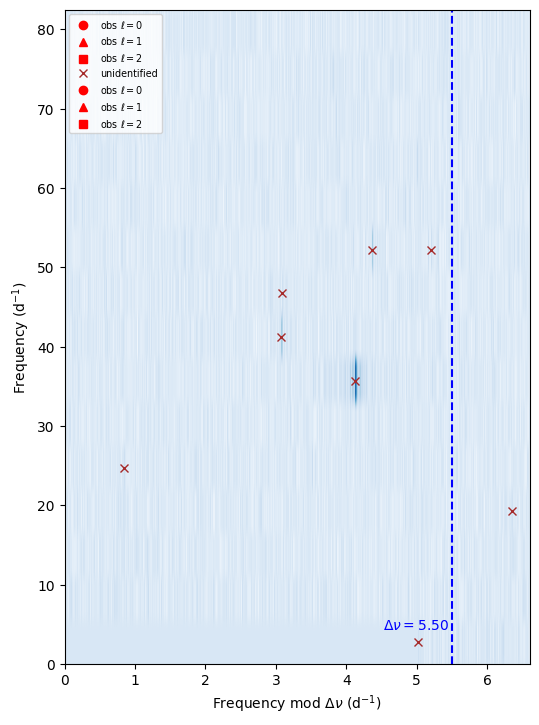

In [63]:
Dnu = 5.5
extra_echelle(freqs, amps, ids1, obs_freqs=ids1, Dnu=Dnu, plain=False)

In [117]:
len(freqs)

171817